In [1]:
import sys
import numpy as np 
import pickle
sys.path.append('../..')
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from lstm import transf_chik_pred
from lstm import apply_dengue_chik
from preprocessing import get_nn_data
from lstm import build_model, transf_chik_pred
from pgbm_model import  cross_dengue_chik_prediction
from sklearn.metrics import mean_squared_error as mse 
import matplotlib.dates as mdates
from plots_pgbm import predicted_vs_observed as p_o_pgbm
from plots_lstm import predicted_vs_observed as p_o_lstm
fmt = mdates.DateFormatter('%d-%b\n%Y')
from scipy.stats import bootstrap

In [2]:
CITY = 2507507
CITY_NAME = 'João Pessoa'
STATE = 'PB'
FILENAME_DATA = f'../../data/chik_{CITY}_cluster.csv'

In [3]:
df_chik = pd.read_csv(FILENAME_DATA, index_col = 'Unnamed: 0' )
df_chik.index = pd.to_datetime(df_chik.index)
df_chik

,casos_2503001,casos_est_2503001,casos_est_min_2503001,casos_est_max_2503001,p_rt1_2503001,p_inc100k_2503001,temp_min_2503001,temp_max_2503001,umid_min_2503001,pressao_min_2503001,...,casos_2504306,casos_est_2504306,casos_est_min_2504306,casos_est_max_2504306,p_rt1_2504306,p_inc100k_2504306,temp_min_2504306,temp_max_2504306,umid_min_2504306,pressao_min_2504306
2010-01-03,0,0.0,0,0,0.0,0.0,25.000000,29.666667,56.666667,1009.666667,...,0,0.0,0,0,0.000000,0.000000,22.666667,31.333333,48.000000,1010.666667
2010-01-10,0,0.0,0,0,0.0,0.0,25.000000,29.428571,59.142857,1010.142857,...,0,0.0,0,0,0.000000,0.000000,22.000000,30.857143,46.571429,1011.000000
2010-01-17,0,0.0,0,0,0.0,0.0,25.000000,29.142857,63.000000,1011.571429,...,0,0.0,0,0,0.000000,0.000000,22.142857,30.571429,46.857143,1012.714286
2010-01-24,0,0.0,0,0,0.0,0.0,24.142857,29.000000,67.000000,1010.714286,...,0,0.0,0,0,0.000000,0.000000,21.714286,30.285714,48.142857,1011.571429
2010-01-31,0,0.0,0,0,0.0,0.0,24.857143,30.000000,56.714286,1009.142857,...,0,0.0,0,0,0.000000,0.000000,22.428571,31.142857,49.000000,1010.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-13,0,0.0,0,0,0.0,0.0,24.285714,29.000000,65.580460,1011.000000,...,0,0.0,0,0,0.000000,0.000000,21.285714,28.714286,56.140008,1012.714286
2022-11-20,0,0.0,0,0,0.0,0.0,25.142857,28.857143,65.968526,1011.714286,...,0,0.0,0,0,0.000000,0.000000,21.333333,27.833333,58.951291,1013.166667
2022-11-27,0,0.0,0,0,0.0,0.0,24.857143,28.285714,64.825027,1010.000000,...,1,1.0,1,1,0.814454,3.259028,20.000000,23.666667,78.238845,1012.333333
2022-12-04,0,0.0,0,0,0.0,0.0,25.142857,28.714286,64.750912,1007.857143,...,0,0.0,0,0,0.000000,0.000000,21.666667,27.000000,59.649207,1008.666667


In [4]:
df_chik.shape[1]

80

<AxesSubplot:>

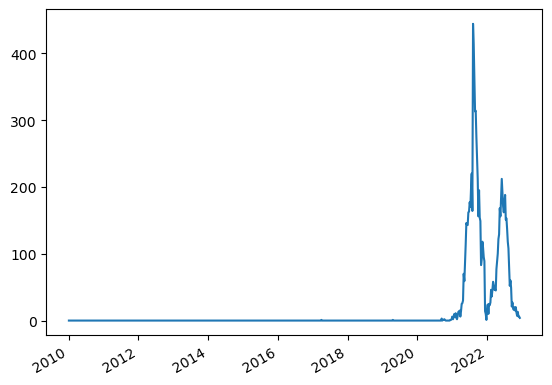

In [5]:
df_chik[f'casos_est_{CITY}'].plot()

In [6]:
INI_DATE = '2021-01-01'
END_DATE = '2022-12-11'

PREDICT_N = 4 # number of new days predicted
LOOK_BACK = 4 # number of last days used to make the prediction 
EPOCHS = 400
HIDDEN = 8
FEAT = 104 # number of features 

Apply the dengue model:

2023-03-11 20:01:54.434200: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


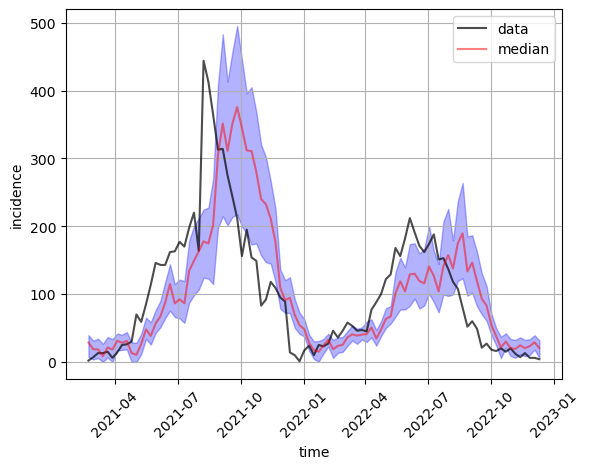

In [7]:
metrics = apply_dengue_chik(CITY, ini_date = INI_DATE, 
                         end_date = END_DATE, look_back = LOOK_BACK,
                         predict_n = PREDICT_N,  label_m = f'msle_all', filename = FILENAME_DATA )

Applying the **transfer learning** techinique:

- Using the model trained with `loss = 'msle'`:


Compilation Time :  0.005924224853515625
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 4, 104)]          0         
                                                                 
 bidirectional_1 (Bidirectio  (None, 4, 8)             7232      
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 4, 8)              0         
                                                                 
 lstm_1 (LSTM)               (None, 8)                 544       
                                                                 
 dropout_2 (Dropout)         (None, 8)                 0         
   

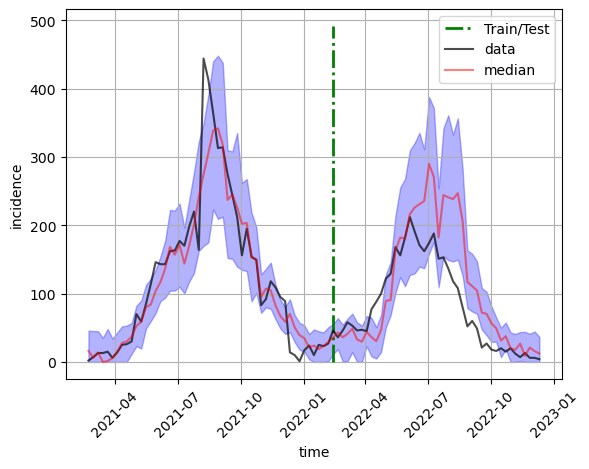

In [8]:

END_DATE_TRAIN = f'2022-02-06'

model = build_model(hidden = HIDDEN, features = FEAT, predict_n = PREDICT_N, look_back=LOOK_BACK, batch_size=1, loss = 'msle')

    
m_msle, m_t, m_val = transf_chik_pred(model, CITY, ini_date = INI_DATE, end_train_date = END_DATE_TRAIN,  
                                end_date = END_DATE, filename = f'../../saved_models/lstm/trained_{CITY}_model_msle_all.h5',  epochs= EPOCHS, features = FEAT,  
                                predict_n = PREDICT_N, look_back = LOOK_BACK, loss = 'msle' , validation_split = 0.0,
                                label = f'transf_msle', filename_data = FILENAME_DATA)

Apply the pgbm model:

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


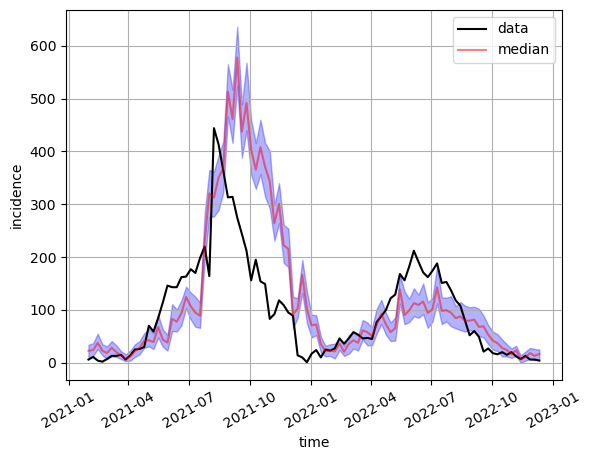

In [9]:
preds, preds25, preds975, X_data, targets = cross_dengue_chik_prediction(CITY, STATE, predict_n = PREDICT_N, look_back = LOOK_BACK, ini_date = INI_DATE, end_date = END_DATE, filename = FILENAME_DATA)
    